# COMP47590 - Advanced Machine Learning 

## PPO for Atari Breakout - Learning from an Image Stack
Uses PPO actor-critic agent to train a neural network based player for the Atari Breakout game from OpenAI gym. This uses an image stack state representation.

### Initialisation

If using Google colab you need to install packages - comment out lines below.

In [1]:
#!apt install swig cmake ffmpeg
#!apt-get install -y xvfb x11-utils
#!pip install stable-baselines3[extra] pyglet box2d box2d-kengz
#!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate

For Google colab comment out this cell to make a virtual rendering canvas so render calls work (we still wont; see display!)

In [2]:
#import pyvirtualdisplay
#
#_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
#                                    size=(1400, 900))
#_ = _display.start()

If using Google colab you need to download and unpackage the game roms - comment out lines below.

In [3]:
#import urllib.request
#urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
#!pip install unrar
#!unrar x Roms.rar
#!mkdir rars
#!mv HC\ ROMS.zip   rars
#!mv ROMS.zip  rars
#!python -m atari_py.import_roms rars

Import required packages. 

In [11]:
import gymnasium as gym
import ale_py
import torch
import stable_baselines3 as sb3

import pandas as pd # For data frames and data frame manipulation
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import numpy as np # For general  numeric operations

import matplotlib.pyplot as plt
%matplotlib inline 

import time # For sleep function to slow down Atari simulations

### Create the Environment

Create the Breakout Environment

In [14]:
env = gym.make('Breakout-v4')

To make Atari environmeent accessible to SB3 models we need to add a number of wrappers. SB3 provides a utility function make_atari_env to do this easily. This adds an AtariWrapper, a Monitor wrapper, and a VecEnv wrapper.

In [15]:
env = sb3.common.env_util.make_atari_env('Breakout-v4', 
                                         n_envs=1, 
                                         seed=0)

The basic Atari envrionments return one frame as an observation, but we need assemble a number of frames into a stack for a state repreentaiton. 

In [16]:
env = sb3.common.vec_env.VecFrameStack(env, n_stack=4)

### Create and Train an Agent

Create PPO agent using a CNN policy and hyper-parameters based on the Atari games Nature paper.

In [17]:
tb_log = './log_tb_breakout_PPO/'
agent = sb3.PPO('CnnPolicy', 
                env,
                n_steps = 128,
                n_epochs = 4,
                batch_size = 256,
                learning_rate = 0.00025,
                clip_range = 0.1,
                vf_coef = 0.5,
                ent_coef = 0.01,
                verbose = 1, 
                tensorboard_log = tb_log)

Using cpu device
Wrapping the env in a VecTransposeImage.


/Users/bmacnamee/opt/anaconda3/envs/COMP47590_2024/lib/python3.12/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 256, but because the `RolloutBuffer` is of size `n_steps * n_envs = 128`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 128
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=128 and n_envs=1)
  warnings.warn(


Examine the action-value function network architecture.

In [18]:
print(agent.policy)

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3136, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

Create an evalution callback.

In [20]:
eval_env = sb3.common.env_util.make_atari_env('Breakout-v4', 
                                         n_envs=1)
eval_env = sb3.common.vec_env.VecFrameStack(eval_env, n_stack=4)
eval_log_path = './logs_breakout_ppo/'
eval_callback = sb3.common.callbacks.EvalCallback(eval_env, 
                                                  best_model_save_path = eval_log_path,
                                                  log_path = eval_log_path, 
                                                  eval_freq = 50000,
                                                  render = False)

Train the agent for a large number of steps.

In [21]:
agent.learn(total_timesteps=500000, 
            callback = eval_callback,
            tb_log_name="PPO")

Logging to ./log_tb_breakout_PPO/PPO_1


/Users/bmacnamee/opt/anaconda3/envs/COMP47590_2024/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:414: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x143f32930> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x174d8c650>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 199      |
|    ep_rew_mean     | 0.333    |
| time/              |          |
|    fps             | 108      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 128      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 211          |
|    ep_rew_mean          | 0.571        |
| time/                   |              |
|    fps                  | 96           |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 0.0011051409 |
|    clip_fraction        | 0            |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.39        |
|    explained_variance   | -0.00276     |
|    learning_r

KeyboardInterrupt: 

View the evaluation callback details.

/var/folders/bz/lbfg_nj54wd40pqchhwx6ys80000gp/T/ipykernel_9062/112024295.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(evaluation_log_df['timesteps'])


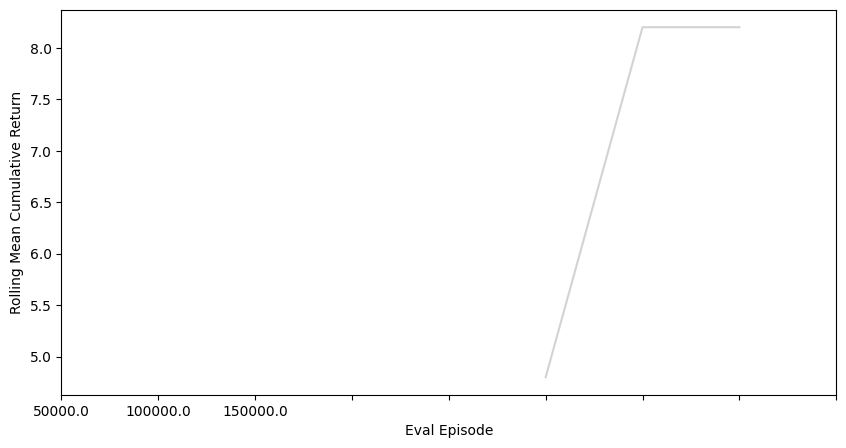

In [22]:
evaluation_log = np.load(eval_log_path + 'evaluations.npz')
evaluation_log_df = pd.DataFrame({item: [np.mean(ep) for ep in evaluation_log[item]] for item in evaluation_log.files})
ax = evaluation_log_df.loc[0:len(evaluation_log_df), 'results'].plot(color = 'lightgray', xlim = [-5, len(evaluation_log_df)], figsize = (10,5))
evaluation_log_df['results'].rolling(5).mean().plot(color = 'black', xlim = [-5, len(evaluation_log_df)])
ax.set_xticklabels(evaluation_log_df['timesteps'])
ax.set_xlabel("Eval Episode")
plt.ylabel("Rolling Mean Cumulative Return")
plt.show()

Save the trained agent.

In [23]:
agent.save("./ppo_breakout_agent")

### Evaluation

Load the saved agent (so that we can just jump to this cell and see it in action)

In [26]:
agent = sb3.ppo.PPO.load("./ppo_breakout_agent")
agent.set_env(env)

Wrapping the env in a VecTransposeImage.


Evaluate the agent in the environment

In [27]:
mean_reward, std_reward = sb3.common.evaluation.evaluate_policy(agent, 
                                                                agent.get_env(), 
                                                                n_eval_episodes=10,
                                                               render = True)
print("Mean Reward: {} +/- {}".format(mean_reward, std_reward))

Mean Reward: 7.7 +/- 3.1953090617340916


Play a slowed down instance of a game.

In [30]:
obs = env.reset()
done = False
while not done:
    action, _states = agent.predict(obs)        
    obs, reward, done, info = env.step(action)
    env.render()
    time.sleep(0.05) # these environments run very fast so slow things down for viewing!